# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# MIT-BIH Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
    Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
    The final element of each row denotes the class to which that example belongs.



Train Dataset
(87554, 188)
(21892, 188)
The last time value is :  1488.0


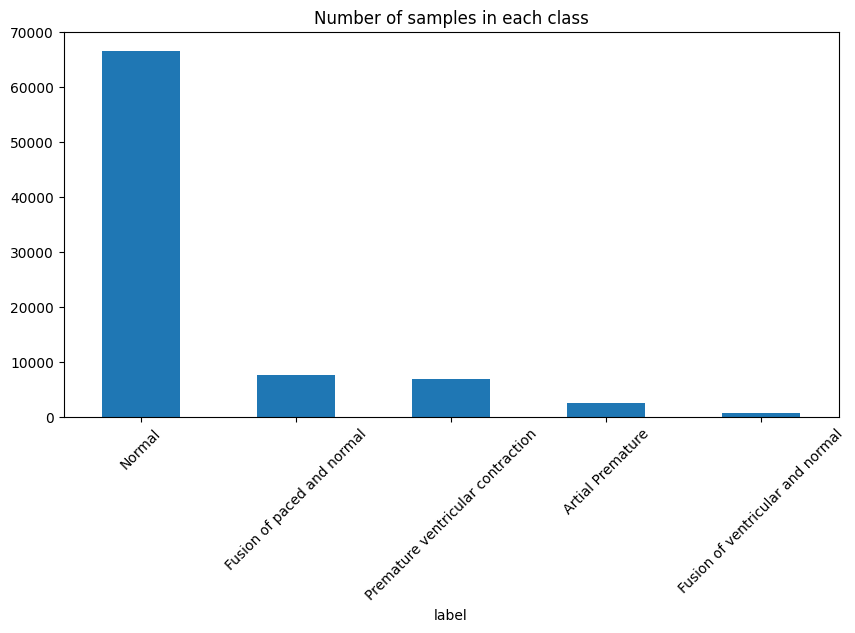

In [2]:
import random

df_mitbih_train = pd.read_csv("/Users/surajkumar/Desktop/LLNL/src/data/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("/Users/surajkumar/Desktop/LLNL/src/data/mitbih_test.csv", header = None)

print("Train Dataset")

print(df_mitbih_train.shape)
print(df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

zero_indices = df_mitbih[df_mitbih['label'] == 0].index

# Randomly select 20% of these indices
indices_to_drop = np.random.choice(zero_indices, size=int(0.2 * len(zero_indices)), replace=False)

df_mitbih = df_mitbih.drop(indices_to_drop)
df_mitbih = df_mitbih.reset_index(drop=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

num_cols = df_mitbih.shape[1] - 1 

time = np.arange(0, num_cols) / 125
time = time * 1000
print("The last time value is : ", time[-1])

df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
counts.plot(kind = "bar")
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

In the plot above, we see that there is a very disproportionate number of normal heartbeats.

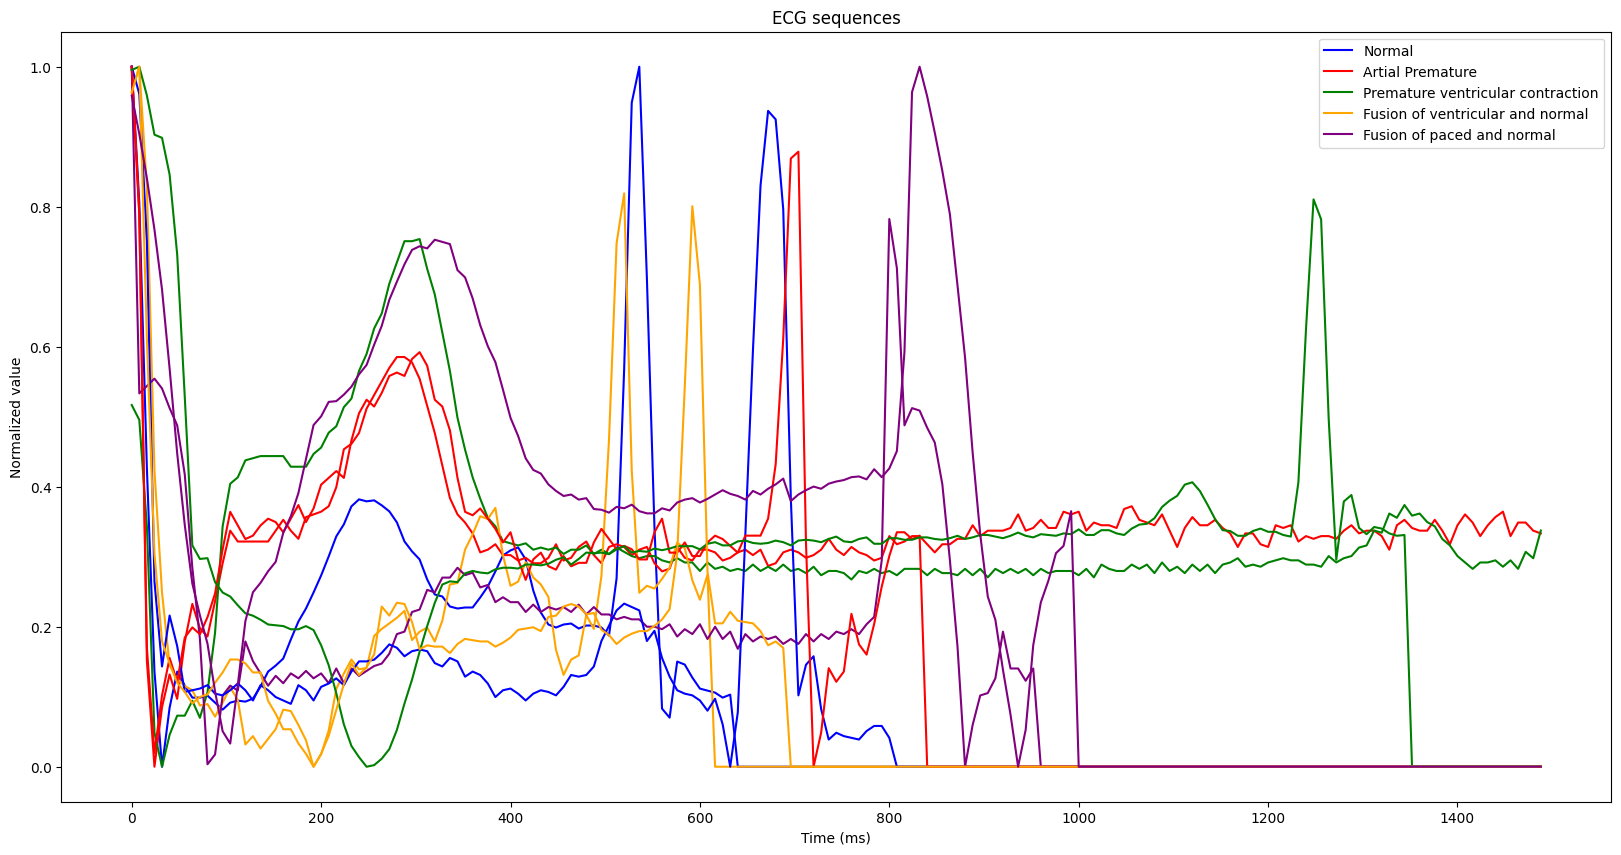

In [3]:
plt.figure(figsize = (20, 10))

colors = ["blue", "red", "green", "orange", "purple"]

for i in range(2):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  

plt.legend()
plt.title("ECG sequences")
plt.ylabel("Normalized value")
plt.xlabel("Time (ms)")
plt.show()
plt.close()

# Data Preparation

In [4]:
from sklearn.model_selection import train_test_split

X = df_mitbih.iloc[:,:-1]
y = df_mitbih.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(67816, 187)
(67816,)
(8477, 187)
(8477,)
(8477, 187)
(8477,)


# Model

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# architecture
model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(layers.Conv1D(32, 3, strides=1, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(32, 3, strides=1, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, strides=1, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(64, 3, strides=1, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
print(model.summary())

# Making weights for each class
weight_0 = (1/counts.iloc[0]) * (len(df_mitbih)/2.0)
weight_1 = (1/counts.iloc[1]) * (len(df_mitbih)/2.0)
weight_2 = (1/counts.iloc[2]) * (len(df_mitbih)/2.0)
weight_3 = (1/counts.iloc[3]) * (len(df_mitbih)/2.0)
weight_4 = (1/counts.iloc[4]) * (len(df_mitbih)/2.0)

class_weight = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3, 4: weight_4}
print("Weights per each class")
print(class_weight)

# loss/optimizer
loss = SparseCategoricalCrossentropy(from_logits=True)
optim = Adam(learning_rate=0.0001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

# training
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight,
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 185, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 183, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 89, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 87, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2752)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       352,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,432 (1.46 MB)

 Trainable params: 382,432 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

None
Weights per each class
{0: 0.6355620867009552, 1: 5.504545454545455, 2: 6.117044306537739, 3: 15.827109783420465, 4: 54.76098191214471}
Epoch 1/20
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2987 - loss: 6.2722 - val_accuracy: 0.5964 - val_loss: 1.0744
Epoch 2/20
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6089 - loss: 2.1077 - val_accuracy: 0.7153 - val_loss: 0.8003
Epoch 3/20
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7330 - loss: 1.4690 - val_accuracy: 0.8043 - val_loss: 0.5930
Epoch 4/20
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7830 - loss: 1.1655 - val_accuracy: 0.8295 - val_loss: 0.5323
Epoch 5/20
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8146 - loss: 1.0262 - val_accuracy: 0.8225 - val_loss: 0.5419
Epoch 6/20
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8341 - loss: 0.9413 - val_accuracy: 0.8825 - val_loss: 0.3844
Epoch 7/20
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8437

# Training and Validation loss/accuracy plots

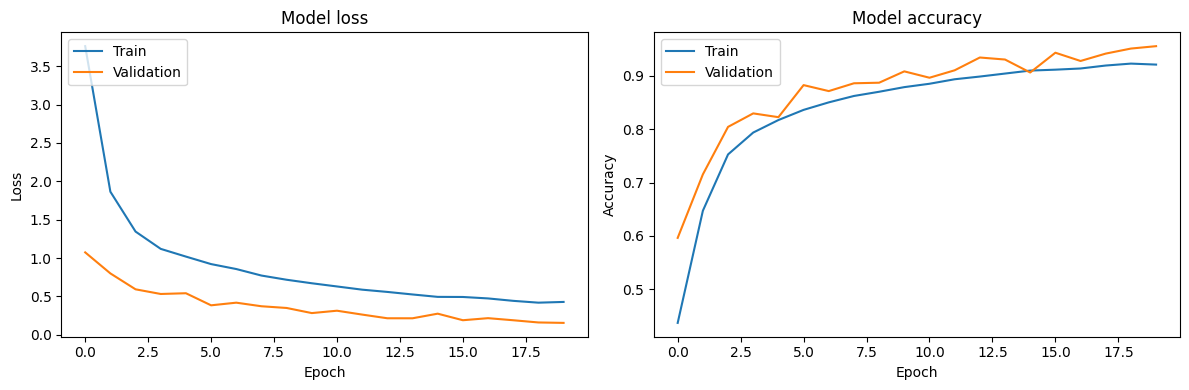

In [10]:
plt.figure(figsize=(12, 4))

# Plot training and validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation acc values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
